In [1]:
import os
os.environ['WANDB_DISABLED'] = 'true'

# Download the Necessary Files

In [2]:
!wget https://raw.githubusercontent.com/actonbp/lead-measure/refs/heads/main/data/processed/ipip_pairs_comprehensive.jsonl
!wget https://github.com/actonbp/lead-measure/raw/refs/heads/main/data/IPIP.csv

--2025-06-03 16:03:37--  https://raw.githubusercontent.com/actonbp/lead-measure/refs/heads/main/data/processed/ipip_pairs_comprehensive.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2476414 (2.4M) [text/plain]
Saving to: ‘ipip_pairs_comprehensive.jsonl’

ipip_pairs_comprehe 100%[===================>]   2.36M  12.9MB/s    in 0.2s    

2025-06-03 16:03:38 (12.9 MB/s) - ‘ipip_pairs_comprehensive.jsonl’ saved [2476414/2476414]

--2025-06-03 16:03:38--  https://github.com/actonbp/lead-measure/raw/refs/heads/main/data/IPIP.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/actonbp/lead-measur

In [26]:
import pandas as pd
import json
import random
from pathlib import Path
import logging
import sys
from collections import defaultdict
from itertools import combinations
import numpy as np


# Configuration
INPUT_CSV = "IPIP.csv"
OUTPUT_JSONL = "ipip_pairs_comprehensive.jsonl"
TEXT_COL = "text"
LABEL_COL = "label"


# Ensure reproducibility
random.seed(42)
np.random.seed(42)

df = pd.read_csv(INPUT_CSV, encoding="latin-1").dropna()

# Group items by construct
construct_to_items = defaultdict(list)
for idx, row in df.iterrows():
    construct_to_items[row[LABEL_COL]].append((row[TEXT_COL]))

# Generate all possible pairs for each construct
construct_pairs_train = {}
construct_pairs_test = {}
total_possible_pairs = 0

construct_list = list(construct_to_items.keys())
threshold = int(len(construct_list)*.8)

construct_to_items_train = construct_list[:threshold]
construct_to_items_test = construct_list[threshold:]

for construct in construct_to_items_train:
    items = construct_to_items[construct]
    if len(items) >= 2:  # Need at least 2 items to form a pair
        # Generate all possible combinations of 2 items within this construct
        pairs = list(combinations(items, 2))
        for i in range(len(pairs)):pairs[i] = tuple(random.sample(pairs[i], len(pairs[i])))
        construct_pairs_train[construct] = pairs
        total_possible_pairs += len(pairs)

for construct in construct_to_items_test:
    items = construct_to_items[construct]
    if len(items) >= 2:  # Need at least 2 items to form a pair
        # Generate all possible combinations of 2 items within this construct
        pairs = list(combinations(items, 2))
        for i in range(len(pairs)):pairs[i] = tuple(random.sample(pairs[i], len(pairs[i])))
        construct_pairs_test[construct] = pairs
        total_possible_pairs += len(pairs)

In [27]:
import random

# Single comprehension: flatten, shuffle, then unzip
shuffled_train = [
    (a, b) if random.random() < 0.5 else (b, a)
    for pairs in construct_pairs_train.values()
    for a, b in pairs
]
shuffled_test = [
    (a, b) if random.random() < 0.5 else (b, a)
    for pairs in construct_pairs_test.values()
    for a, b in pairs
]

anchors_train, positives_train = map(list, zip(*shuffled_train))
anchors_test, positives_test = map(list, zip(*shuffled_test))

In [28]:
# Find indices of NaN or float values in anchors or positives
indices_to_remove_train = [
    i for i, (anchor, positive) in enumerate(zip(anchors_train, positives_train))
    if isinstance(anchor, float) or isinstance(positive, float)
]

indices_to_remove_test = [
    i for i, (anchor, positive) in enumerate(zip(anchors_test, positives_test))
    if isinstance(anchor, float) or isinstance(positive, float)
]


# Remove elements at these indices from both lists
cleaned_anchors_train = [anchors_train[i] for i in range(len(anchors_train)) if i not in indices_to_remove_train]
cleaned_positives_train = [positives_train[i] for i in range(len(positives_train)) if i not in indices_to_remove_train]

cleaned_anchors_test = [anchors_test[i] for i in range(len(anchors_test)) if i not in indices_to_remove_test]
cleaned_positives_test = [positives_test[i] for i in range(len(positives_test)) if i not in indices_to_remove_test]


# Update the original lists (optional, but good practice if you intend to continue using these variables)
anchors_train = cleaned_anchors_train
positives_train = cleaned_positives_train

anchors_test = cleaned_anchors_test
positives_test = cleaned_positives_test

In [33]:
mask = df['label'].isin(construct_to_items_train)

In [39]:
all_train_items = df[mask]['text'].unique().tolist()

In [55]:
from torch.utils.data import DataLoader
from sentence_transformers import (
    SentenceTransformer,
    models,
    InputExample,
    SentenceTransformerTrainer,
    losses,
)

#
# ─── 1) TSDAE PRETRAINING ──────────────────────────────────────────────────────────
#

# a) Build a TSDAE model: encoder + pooling + decoder (tied weights)
word_emb   = models.Transformer("/projects/interactiveaccount/SIOP/bge-m3")
pooling    = models.Pooling(word_emb.get_word_embedding_dimension(), "cls")
tsdae_model = SentenceTransformer(modules=[word_emb, pooling])

In [56]:
from sentence_transformers import models, util, datasets, evaluation, losses
# b) Prepare *unlabeled* corpus of raw sentences for self-supervised denoising
#    (you can use all your anchor+positive texts, or a larger pool of domain text)

train_dataset = datasets.DenoisingAutoEncoderDataset(all_train_items[::])
tsdae_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# c) TSDAE loss: corrupt input and reconstruct
tsdae_loss = losses.DenoisingAutoEncoderLoss(
    model=tsdae_model,
    tie_encoder_decoder=True,
)

Some weights of XLMRobertaForCausalLM were not initialized from the model checkpoint at /projects/interactiveaccount/SIOP/bge-m3 and are newly initialized: ['encoder.layer.0.crossattention.output.LayerNorm.bias', 'encoder.layer.0.crossattention.output.LayerNorm.weight', 'encoder.layer.0.crossattention.output.dense.bias', 'encoder.layer.0.crossattention.output.dense.weight', 'encoder.layer.0.crossattention.self.key.bias', 'encoder.layer.0.crossattention.self.key.weight', 'encoder.layer.0.crossattention.self.query.bias', 'encoder.layer.0.crossattention.self.query.weight', 'encoder.layer.0.crossattention.self.value.bias', 'encoder.layer.0.crossattention.self.value.weight', 'encoder.layer.1.crossattention.output.LayerNorm.bias', 'encoder.layer.1.crossattention.output.LayerNorm.weight', 'encoder.layer.1.crossattention.output.dense.bias', 'encoder.layer.1.crossattention.output.dense.weight', 'encoder.layer.1.crossattention.self.key.bias', 'encoder.layer.1.crossattention.self.key.weight', 'en

In [42]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ivanhernandez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [57]:
# Call the fit method
tsdae_model.fit(
    train_objectives=[(tsdae_dataloader, tsdae_loss)],
    epochs=1,
    weight_decay=0,
    scheduler="constantlr",
    optimizer_params={"lr": 3e-5},
    show_progress_bar=True,
)

#tsdae_model.save("tsdae-model")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/home/ivanhernandez/.local/lib/python3.11/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


In [45]:
!nvidia-smi

Tue Jun  3 16:19:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H200                    On  |   00000000:CB:00.0 Off |                    0 |
| N/A   41C    P0            125W /  700W |   13856MiB / 143771MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [58]:
from sentence_transformers import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
args = SentenceTransformerTrainingArguments(
        output_dir="gist_model",
        # Optional training parameters:
        num_train_epochs=60,
        per_device_train_batch_size=256,
        do_eval=True,
        eval_strategy="steps",
        eval_steps=500,
        learning_rate=2e-6,
        warmup_ratio=0.1,
        fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
        bf16=False,  # Set to True if you have a GPU that supports BF16
        batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
        save_strategy="no",
    )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [59]:
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, losses
from datasets import Dataset

#tsdae_model = SentenceTransformer("tsdae-model")

guide = SentenceTransformer("/projects/interactiveaccount/SIOP/all-MiniLM-L6-v2")
train_dataset = Dataset.from_dict({
    "anchor": anchors_train,
    "positive": positives_train,
})

test_dataset = Dataset.from_dict({
    "anchor": anchors_test,
    "positive": positives_test,
})

loss = losses.GISTEmbedLoss(tsdae_model, guide)


trainer = SentenceTransformerTrainer(
    model=tsdae_model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss=loss,
    args=args
)
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/home/ivanhernandez/.local/lib/python3.11/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss
500,5.475100,1.136727
1000,2.637300,0.935371
1500,2.566300,0.972631
2000,2.396400,0.950059
2500,1.843800,1.005253
3000,2.381500,0.990273
3500,1.826300,1.018997
4000,1.904300,1.039671
4500,2.033300,1.052441


KeyboardInterrupt: 

In [ ]:
tsdae_model.save("trained_gist_model4")

In [68]:
embeddings = tsdae_model.encode(df[mask]['text'].tolist())

In [67]:
tsdae_model.save_pretrained("/projects/interactiveaccount/Leadershiptrained")

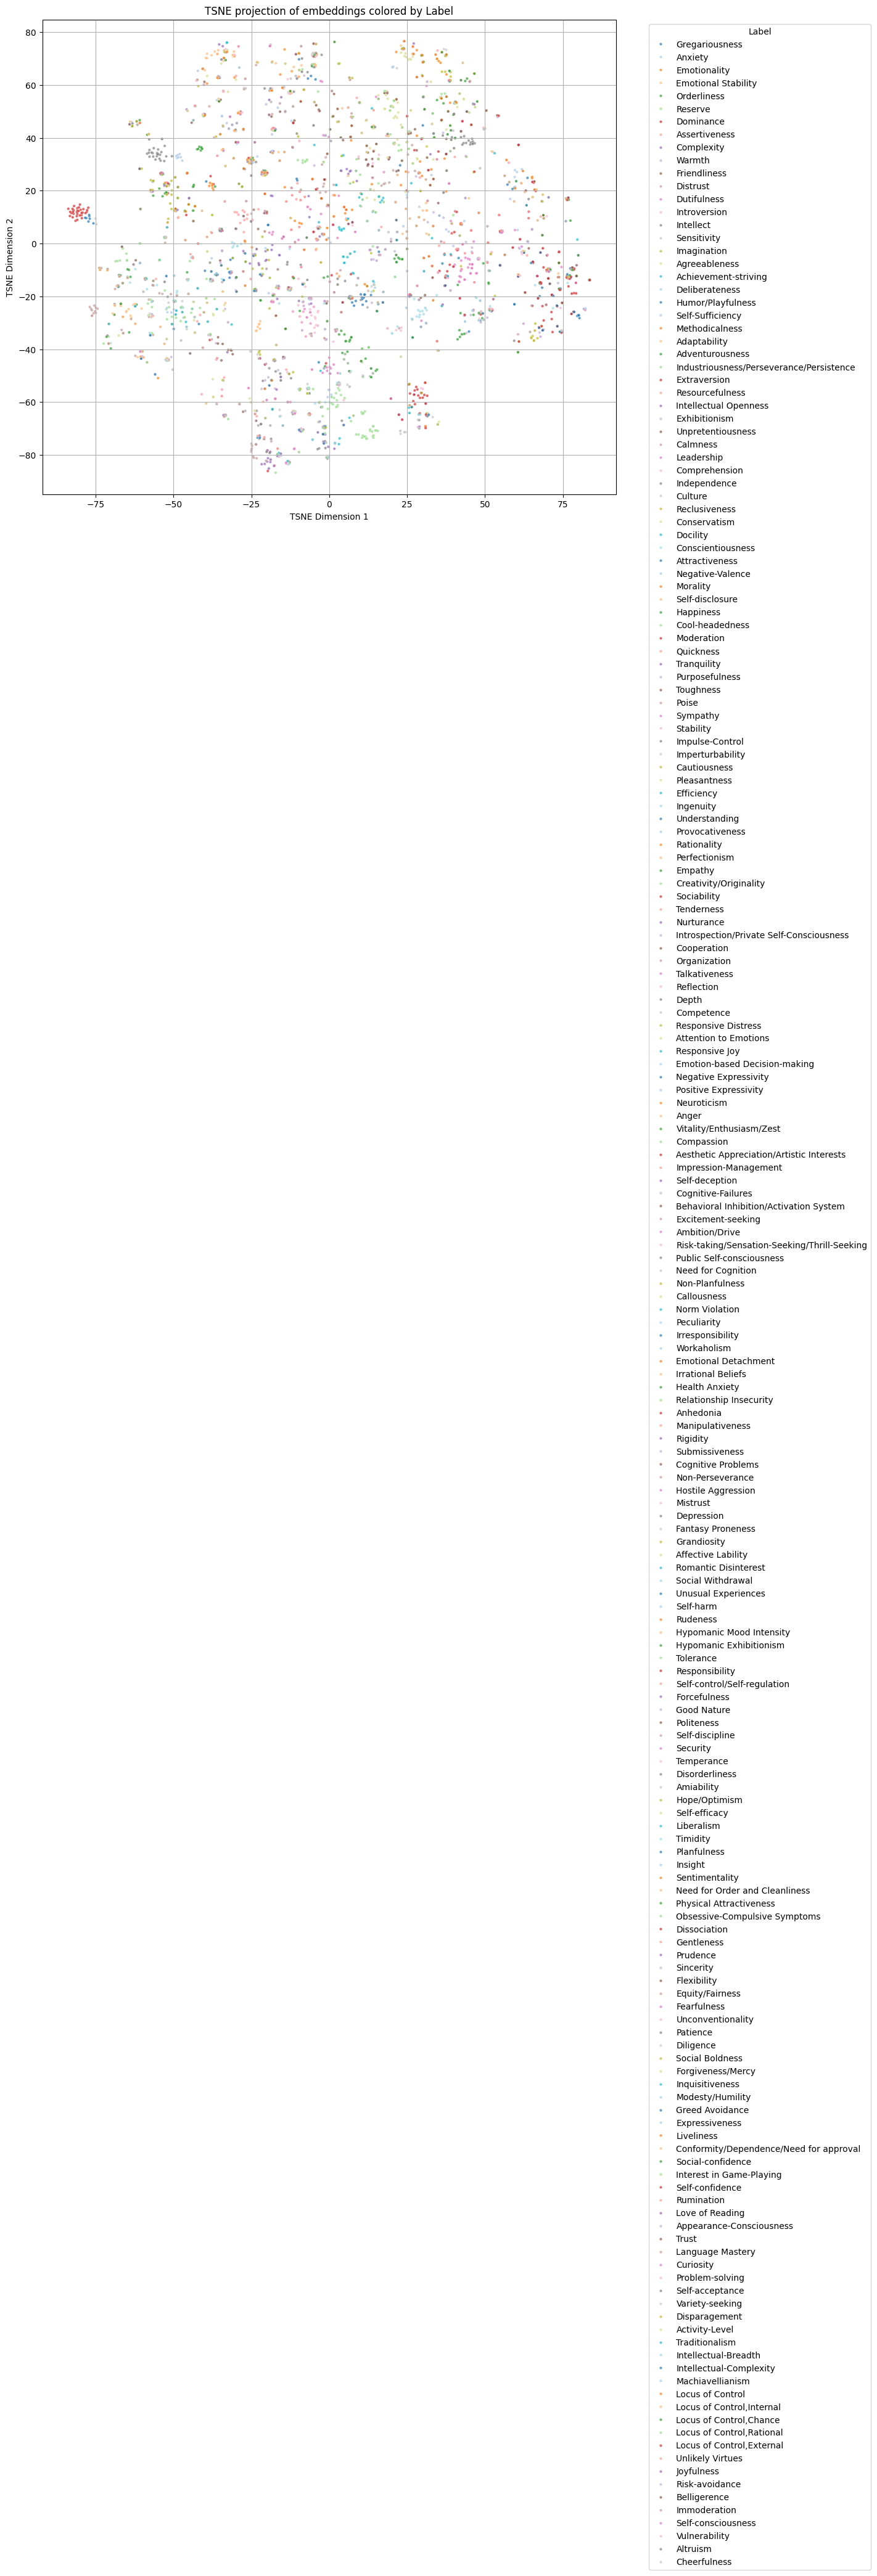

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE
import seaborn as sns
# 1. t-SNE projection
tsne = TSNE(n_components=2, perplexity=30,
            learning_rate='auto', init='random', random_state=999)
tsne_embeddings = tsne.fit_transform(embeddings)

# Get the labels
labels = df[mask]['label'].tolist()

# Create a DataFrame for plotting
plot_df = pd.DataFrame(tsne_embeddings, columns=['TSNE Dimension 1', 'TSNE Dimension 2'])
plot_df['label'] = labels

# Create a color map for labels
unique_labels = plot_df['label'].unique()
num_labels = len(unique_labels)
colors = sns.color_palette("hsv", num_labels)
label_color_map = dict(zip(unique_labels, colors))

# Plot the embeddings
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x="TSNE Dimension 1",
    y="TSNE Dimension 2",
    hue="label",
    palette='tab20',
    data=plot_df,
    s=10,
    alpha=0.7
)
plt.title('TSNE projection of embeddings colored by Label')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [62]:
df_test = df[~mask]

In [63]:
text_counts = df_test.groupby('text')['label'].nunique()
unique_texts = text_counts[text_counts == 1].index
df_unique = df_test[df_test['text'].isin(unique_texts)].copy()

label_counts = df_unique['label'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
df_unique = df_unique[df_unique['label'].isin(valid_labels)].copy()


embeddings = tsdae_model.encode(df_unique['text'].tolist())

df_unique['embedding'] = list(embeddings)

In [65]:
import random

# Group by label to facilitate random sampling within each label
grouped_by_label = df_unique.groupby('label')

# Convert each label's indices to a list for random sampling
label_to_indices = {
    label: group.index.tolist() for label, group in grouped_by_label
}

# A helper function to compute cosine similarity
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

same_label_sims = []
diff_label_sims = []

all_indices = df_unique.index.tolist()

for idx, row in df_unique.iterrows():
    label = row['label']
    emb = row['embedding']

    # --- Same-label item ---
    same_label_idxs = label_to_indices[label]

    # Exclude the current item from sampling pool
    same_label_idxs = [i for i in same_label_idxs if i != idx]
    if not same_label_idxs:
        # If there's only one item in that label, skip or handle accordingly
        same_label_sims.append(np.nan)
        diff_label_sims.append(np.nan)
        continue

    # Randomly pick one item from the same label
    random_same_idx = random.choice(same_label_idxs)
    same_emb = df_unique.loc[random_same_idx, 'embedding']

    # Compute cosine similarity with same-construct item
    sim_same = cosine_similarity(emb, same_emb)

    # --- Different-label item ---
    # All indices minus the same label’s indices
    different_label_idxs = list(set(all_indices) - set(label_to_indices[label]))
    if not different_label_idxs:
        # If everything is the same label, skip or handle accordingly
        same_label_sims.append(np.nan)
        diff_label_sims.append(np.nan)
        continue

    # Randomly pick one item from a different label
    random_diff_idx = random.choice(different_label_idxs)
    diff_emb = df_unique.loc[random_diff_idx, 'embedding']

    # Compute cosine similarity with different-construct item
    sim_diff = cosine_similarity(emb, diff_emb)

    same_label_sims.append(sim_same)
    diff_label_sims.append(sim_diff)

df_unique['similarity_same_construct'] = same_label_sims
df_unique['similarity_diff_construct'] = diff_label_sims

df_unique[['text','label','similarity_same_construct','similarity_diff_construct']]

,text,label,similarity_same_construct,similarity_diff_construct
2917,Am not interested in abstract ideas.,Openness To Experience,0.819621,0.835341
2918,Am not interested in theoretical discussions.,Openness To Experience,0.854659,0.725726
2923,Avoid philosophical discussions.,Openness To Experience,0.836807,0.791070
2924,Believe in the importance of art.,Openness To Experience,0.919746,0.848438
2927,Believe that too much tax money goes to suppor...,Openness To Experience,0.796382,0.745449
...,...,...,...,...
3791,Try not to do favors for others.,Kindness/Generosity,0.827824,0.777706
3794,Try to have good reasons for my important deci...,Judgment/Open-mindedness,0.902149,0.806335
3795,Try to identify the reasons for my actions.,Judgment/Open-mindedness,0.865602,0.814867
3801,Weigh the pro's and the con's.,Judgment/Open-mindedness,0.816627,0.696588


In [66]:
from scipy.stats import ttest_rel
# 4) Paired t-test, Cohen’s d, probability
df_valid = df_unique.dropna(subset=['similarity_same_construct','similarity_diff_construct'])
same = df_valid['similarity_same_construct'].values
diff = df_valid['similarity_diff_construct'].values

t_stat, p_val = ttest_rel(same, diff)
print(f"Paired t-test: t={t_stat:.3f}, p={p_val:.3e}")

differences = same - diff
mean_diff = np.mean(differences)
std_diff = np.std(differences, ddof=1)
cohens_d = mean_diff / std_diff
print(f"Cohen's d (paired) = {cohens_d:.3f}")

prob_same_higher = np.mean(same > diff)
print(f"Probability(same > diff) = {prob_same_higher:.2%}")

Paired t-test: t=30.411, p=8.220e-109
Cohen's d (paired) = 1.472
Probability(same > diff) = 92.97%
